# Time Series Forecasting of Cryptocurrencies

# IMPORTS

In [2]:
# install
# !pip install pmdarima --quiet

# analysis
import pandas as pd
import numpy as np
import glob
import json
import os

# # define random seed of numpy
seed_value = 42
np.random.seed(seed_value)

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as plx
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [16, 4]

# # progress
import traceback
from tqdm import tqdm
tqdm.pandas(desc="Processing Rows")

# # output
import warnings
warnings.filterwarnings('ignore')

# # forecast
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# # expand display output
pd.set_option('display.max_columns', None)

# ENGINEERING

Lendo todos os arquivos da pasta ``raw_data``, e armazenando um arquivo concatenado identificando cada dataset pelo ticker do criptoativo

In [ ]:
# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")

# Dicionário para armazenar os DataFrames tratados
data_frames = {}

for file_name in file_names:
    # Obtendo o nome do arquivo sem a extensão
    name = file_name.split('/')[-1].split('.')[0]

    # Lendo o arquivo CSV e aplicando os tratamentos
    df = pd.read_csv(file_name, sep=';')
    cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
    cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
    df = df[cols_to_keep].rename(columns=cols_to_rename)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Extrair o ticker da parte inicial do nome da chave
    ticker = name.split('_')[0]

    # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
    df['ticker'] = ticker

    # Armazenando o DataFrame tratado no dicionário
    data_frames[name] = df

# Acesse cada DataFrame usando seus nomes de arquivo como chaves, por exemplo:
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [ ]:
def processar_arquivos_csv(diretorio):
    """
    Processa arquivos CSV em um diretório específico.

    Parameters:
    - diretorio (str): O caminho do diretório que contém os arquivos CSV.

    Returns:
    - data_frames (dict): Um dicionário contendo DataFrames tratados, onde as chaves são os nomes dos arquivos.

    Example:
    >>> diretorio = "../path/para/raw_data/"
    >>> data_frames = processar_arquivos_csv(diretorio)
    >>> print(data_frames.keys())
    dict_keys(['nome_arquivo1', 'nome_arquivo2', ...])
    """
    # Obtendo a lista de nomes de arquivo no diretório
    file_names = glob.glob(f"{diretorio}/*")

    # Dicionário para armazenar os DataFrames tratados
    data_frames = {}

    for file_name in file_names:
        # Obtendo o nome do arquivo sem a extensão
        name = file_name.split('/')[-1].split('.')[0]

        # Lendo o arquivo CSV e aplicando os tratamentos
        df = pd.read_csv(file_name, sep=';')
        cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
        cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
        df = df[cols_to_keep].rename(columns=cols_to_rename)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

        # Extrair o ticker da parte inicial do nome da chave
        ticker = name.split('_')[0]

        # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
        df['ticker'] = ticker

        # Armazenando o DataFrame tratado no dicionário
        data_frames[name] = df

    return data_frames

# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")
diretorio = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/"

# Exemplo de uso:
data_frames = processar_arquivos_csv(diretorio)
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [ ]:
data_frames['BTC_All_graph_coinmarketcap']

,close,volume,market_cap,ticker
date,,,,
2013-04-01 00:00:00+00:00,278.528200,0.000000e+00,3.118457e+09,BTC
2013-05-01 00:00:00+00:00,276.292200,0.000000e+00,2.901242e+09,BTC
2013-06-01 00:00:00+00:00,215.594137,0.000000e+00,2.349464e+09,BTC
2013-07-01 00:00:00+00:00,241.503268,0.000000e+00,2.719703e+09,BTC
2013-08-01 00:00:00+00:00,322.417250,0.000000e+00,3.584583e+09,BTC
...,...,...,...,...
2023-08-01 00:00:00+00:00,128500.820776,2.068772e+12,2.386531e+12,BTC
2023-09-01 00:00:00+00:00,135716.038785,1.673128e+12,2.605974e+12,BTC
2023-10-01 00:00:00+00:00,174590.403638,2.397612e+12,3.407242e+12,BTC


In [ ]:
# # concatenando
# df = pd.DataFrame()

# # Concatenar todos os DataFrames no dicionário
# for key, value in data_frames.items():
#     df = pd.concat([df, value])

# # dropando possiveis duplicidades do df 1M
# df = df.drop_duplicates()
# df

def concatenar_dataframes(data_frames):
    """
    Concatena DataFrames de um dicionário e remove possíveis duplicatas.

    Parameters:
    - data_frames (dict): Um dicionário contendo DataFrames a serem concatenados.

    Returns:
    - df_concatenado (pd.DataFrame): O DataFrame resultante após a concatenação e remoção de duplicatas.

    Example:
    >>> data_frames = {'nome_arquivo1': df1, 'nome_arquivo2': df2, ...}
    >>> df_concatenado = concatenar_dataframes(data_frames)
    >>> print(df_concatenado.head())
       close  volume  market_cap  ticker
    date
    ...
    """
    # Criar um DataFrame vazio para a concatenação
    df = pd.DataFrame()

    # Concatenar todos os DataFrames no dicionário
    for value in data_frames.values():
        df = pd.concat([df, value])

    # Remover possíveis duplicatas do DataFrame resultante
    df_concatenado = df.drop_duplicates()

    return df_concatenado

# exemplo
df = concatenar_dataframes(data_frames)
df

,close,volume,market_cap,ticker
date,,,,
2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH
2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH
2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH
2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH
2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH
...,...,...,...,...
2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC
2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC
2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC


In [ ]:
# # format date
# df_month = df.reset_index().copy()
# df_month['month'] = df_month['date'].dt.to_period('M').dt.to_timestamp()

# #df_month


def formatar_data(df):
    """
    Formata a coluna de data e adiciona uma coluna de mês ao DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame a ser formatado.

    Returns:
    - df_formatado (pd.DataFrame): O DataFrame resultante após a formatação da data.

    Example:
    >>> df = pd.DataFrame({'date': ['2022-01-01', '2022-02-01', '2022-03-01'],
    ...                    'close': [100, 105, 98],
    ...                    'volume': [1000, 1200, 900],
    ...                    'market_cap': [5000, 5500, 4800],
    ...                    'ticker': ['AAPL', 'AAPL', 'AAPL']})
    >>> df_formatado = formatar_data(df)
    >>> print(df_formatado.head())
         date  close  volume  market_cap ticker      month
    0 2022-01-01    100    1000        5000   AAPL 2022-01-01
    1 2022-02-01    105    1200        5500   AAPL 2022-02-01
    2 2022-03-01     98     900        4800   AAPL 2022-03-01
    """
    # Criar uma cópia do DataFrame para evitar modificações indesejadas
    df_copy = df.reset_index().copy()

    # Adicionar uma coluna de mês ao DataFrame
    df_copy['month'] = df_copy['date'].dt.to_period('M').dt.to_timestamp()

    return df_copy

df_month = formatar_data(df)
df_month

,date,close,volume,market_cap,ticker,month
0,2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH,2023-12-01
1,2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH,2023-12-01
2,2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH,2023-12-01
3,2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH,2023-12-01
4,2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH,2023-12-01
...,...,...,...,...,...,...
3170,2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC,2024-01-01
3171,2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC,2024-01-01
3172,2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC,2024-01-01
3173,2024-01-15 00:00:00+00:00,206769.708598,1.083422e+11,4.044428e+12,BTC,2024-01-01


In [ ]:
# df_month[df_month["ticker"] == "BCH"].sort_values(by="month").tail(20)

In [ ]:
# df_month_mean = df_month.groupby(["month",  "ticker"]).agg(
#     close_mean = ("close", "mean"),
#     volume_mean = ("volume", "mean"),
#     market_cap_mean = ("market_cap", "mean")
# ).reset_index()

def calcular_medias_por_mes(df):
    """
    Calcula médias por mês e ticker a partir de um DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame contendo os dados a serem agregados.

    Returns:
    - df_agregado (pd.DataFrame): O DataFrame resultante após a agregação por mês e ticker.

    Example:
    >>> df = pd.DataFrame({'date': ['2022-01-01', '2022-01-01', '2022-02-01', '2022-02-01'],
    ...                    'close': [100, 110, 105, 108],
    ...                    'volume': [1000, 1200, 900, 950],
    ...                    'market_cap': [5000, 5500, 4800, 5200],
    ...                    'ticker': ['AAPL', 'AAPL', 'AAPL', 'AAPL']})
    >>> df_agregado = calcular_medias_por_mes(df)
    >>> print(df_agregado.head())
         month ticker  close_mean  volume_mean  market_cap_mean
    0 2022-01-01   AAPL       105.0       1100.0           5250.0
    1 2022-02-01   AAPL       106.5        925.0           5000.0
    """
    # Agrupar por mês e ticker, calculando as médias
    df_agregado = df.groupby(["month", "ticker"]).agg(
        close_mean=("close", "mean"),
        volume_mean=("volume", "mean"),
        market_cap_mean=("market_cap", "mean")
    ).reset_index()

    return df_agregado

# exemplo
df_month_mean = calcular_medias_por_mes(df_month)
df_month_mean

,month,ticker,close_mean,volume_mean,market_cap_mean
0,2013-04-01,BTC,278.528200,0.000000e+00,3.118457e+09
1,2013-05-01,BTC,276.292200,0.000000e+00,2.901242e+09
2,2013-05-01,LTC,6.332617,0.000000e+00,1.074754e+08
3,2013-06-01,BTC,215.594137,0.000000e+00,2.349464e+09
4,2013-06-01,LTC,6.651075,0.000000e+00,1.214861e+08
...,...,...,...,...,...
1492,2024-01-01,TON,10.922831,5.223478e+08,3.771724e+10
1493,2024-01-01,TRX,0.521461,1.510510e+09,4.598489e+10
1494,2024-01-01,USDC,4.882848,3.162273e+10,1.231073e+11
1495,2024-01-01,USDT,4.883774,2.647886e+11,4.572395e+11


In [ ]:
df_month_mean["ticker"].unique()

array(['BTC', 'LTC', 'XRP', 'DOGE', 'USDT', 'ETH', 'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON'], dtype=object)

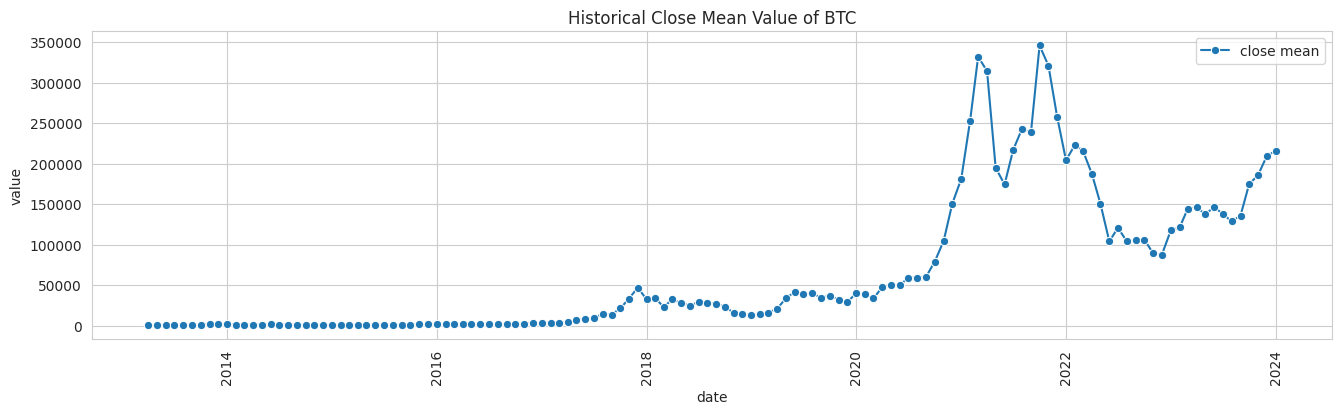

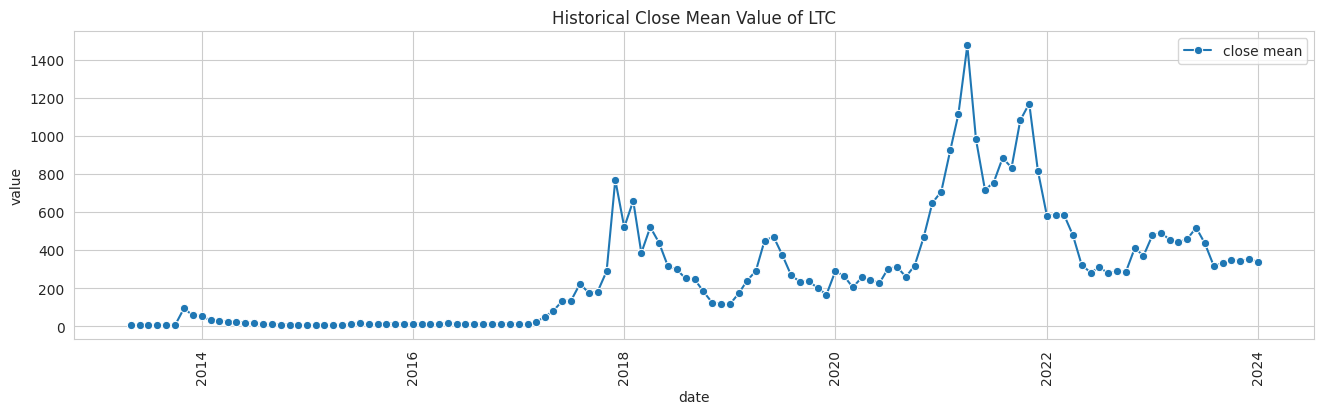

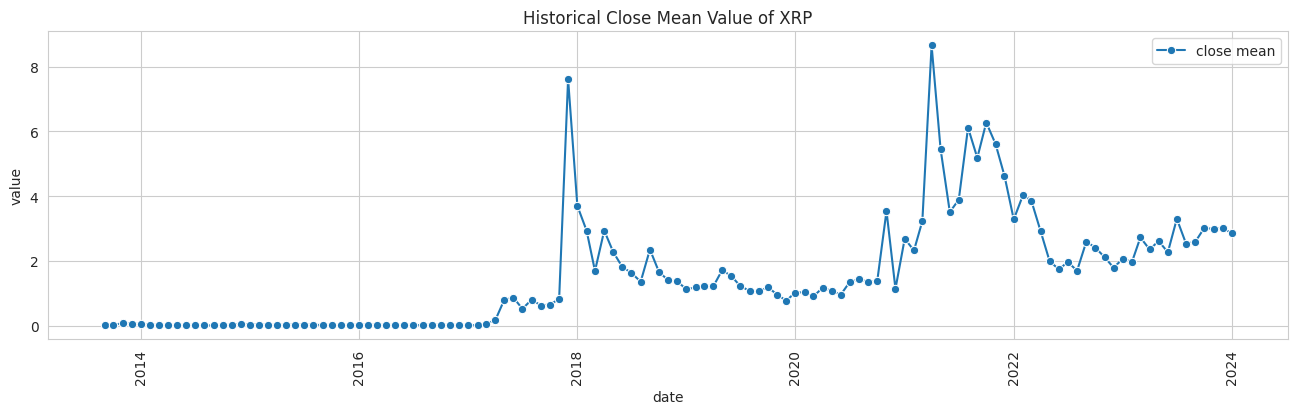

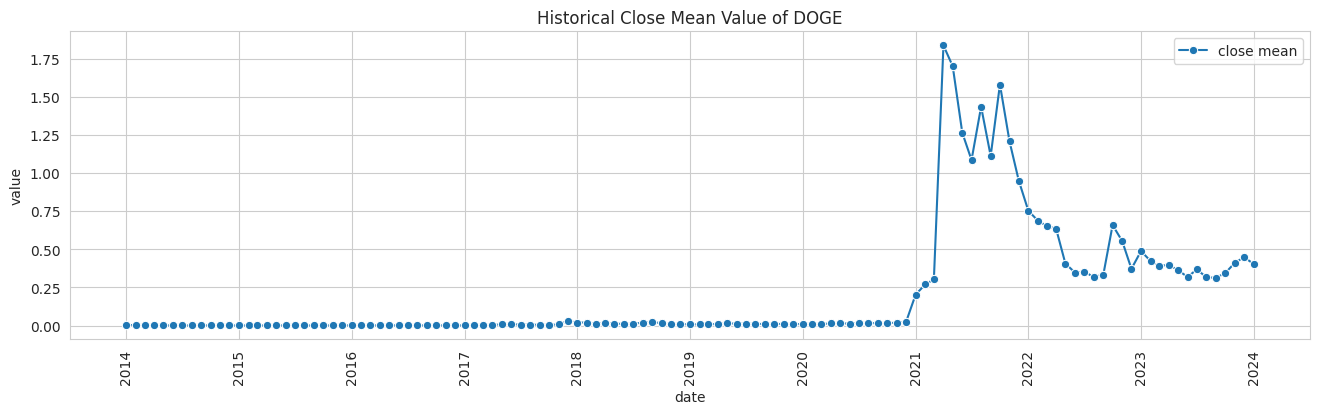

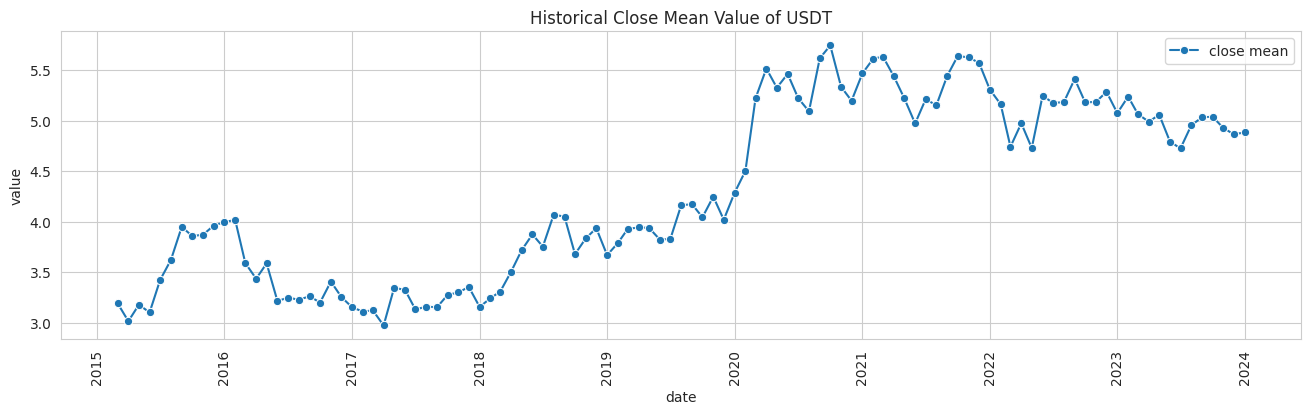

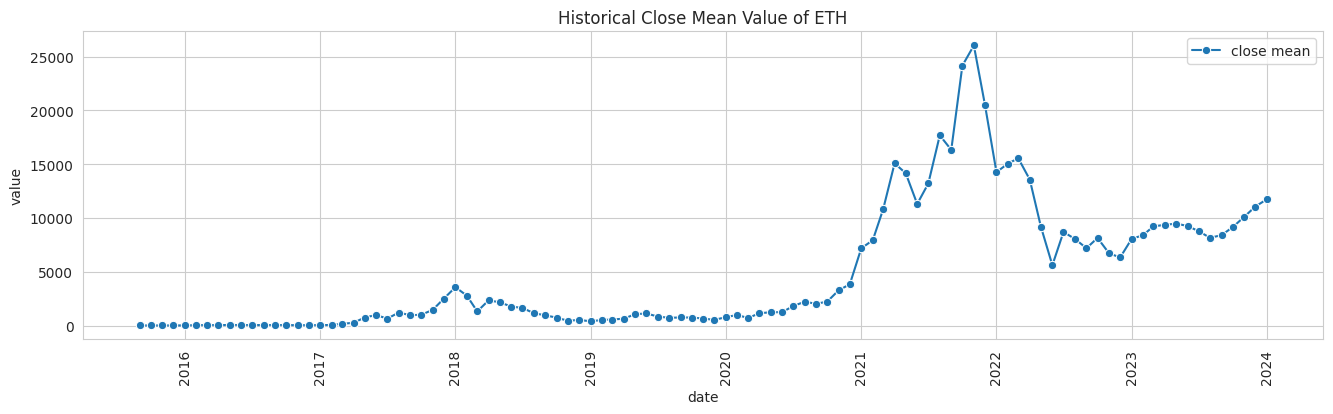

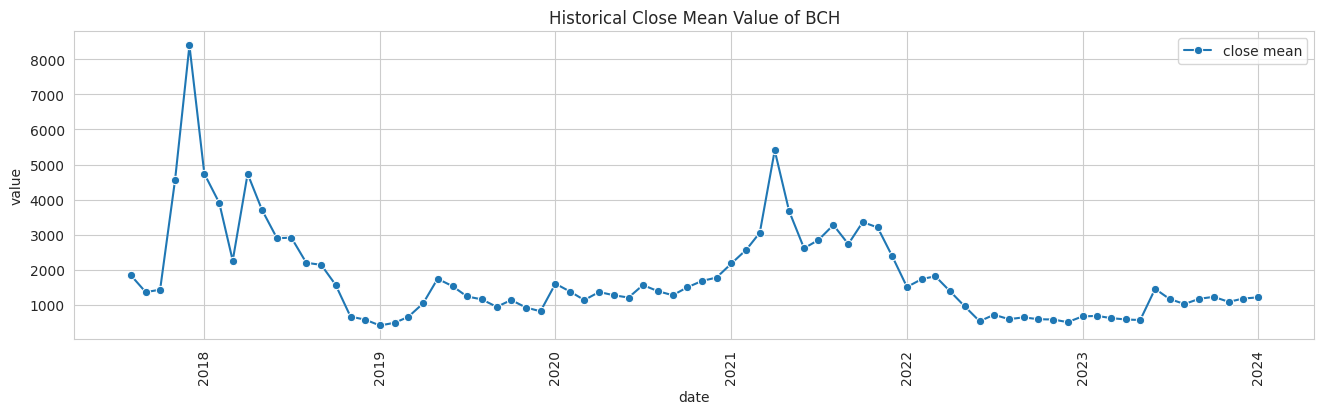

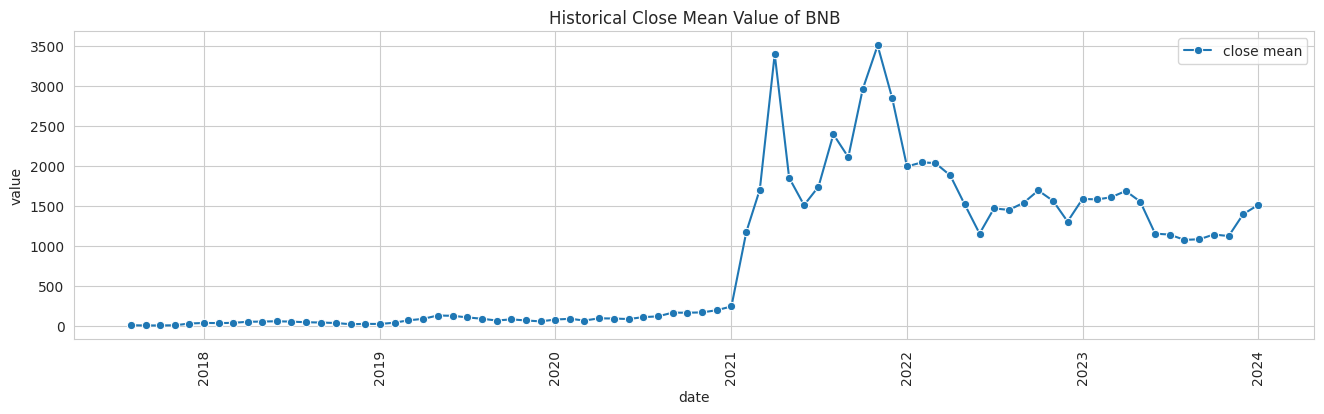

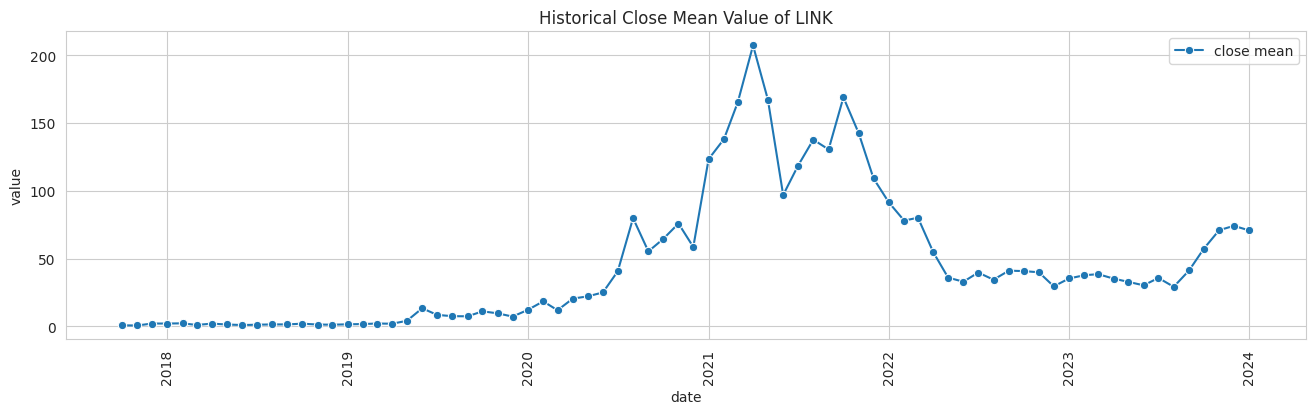

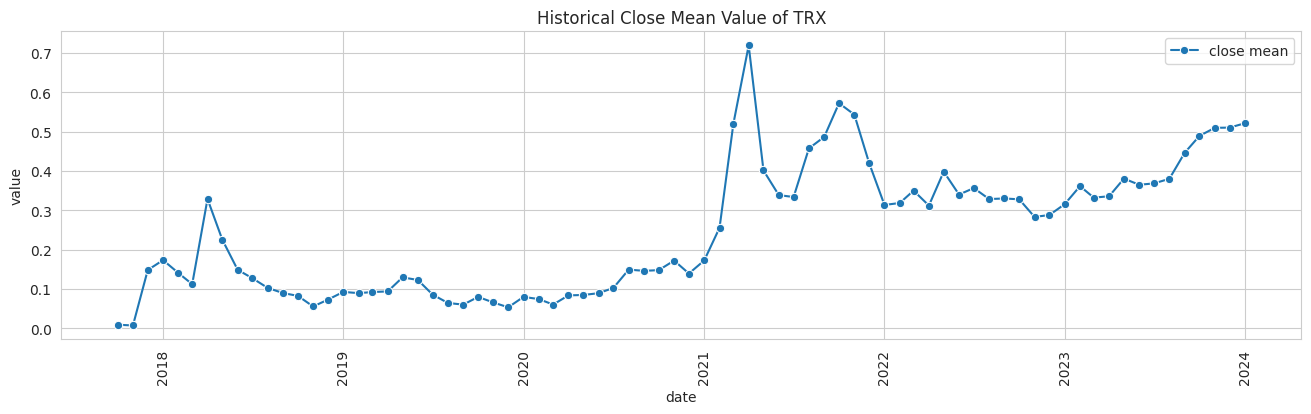

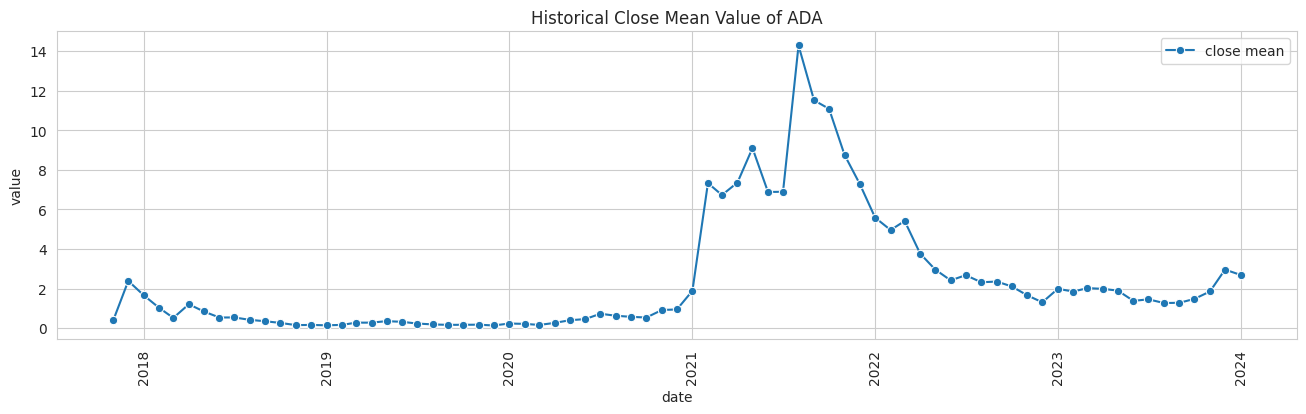

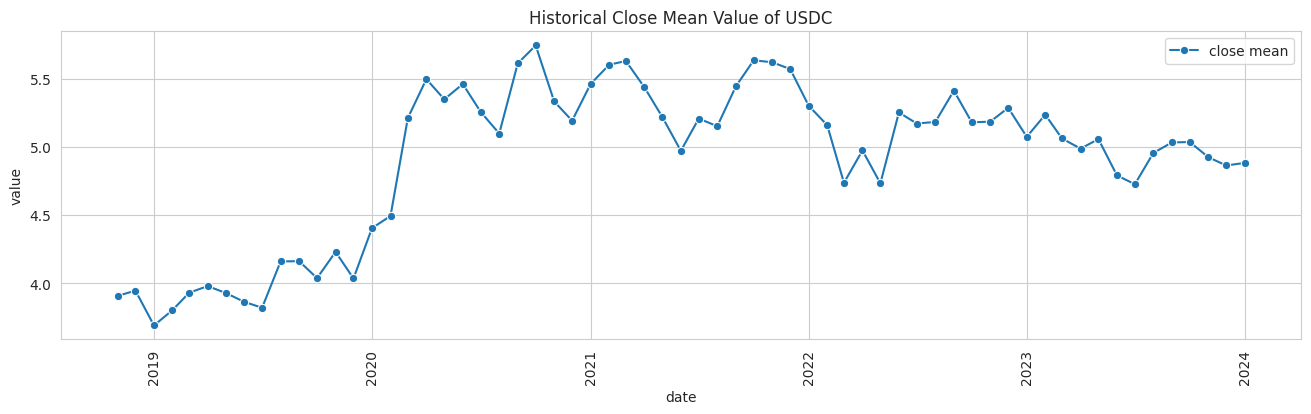

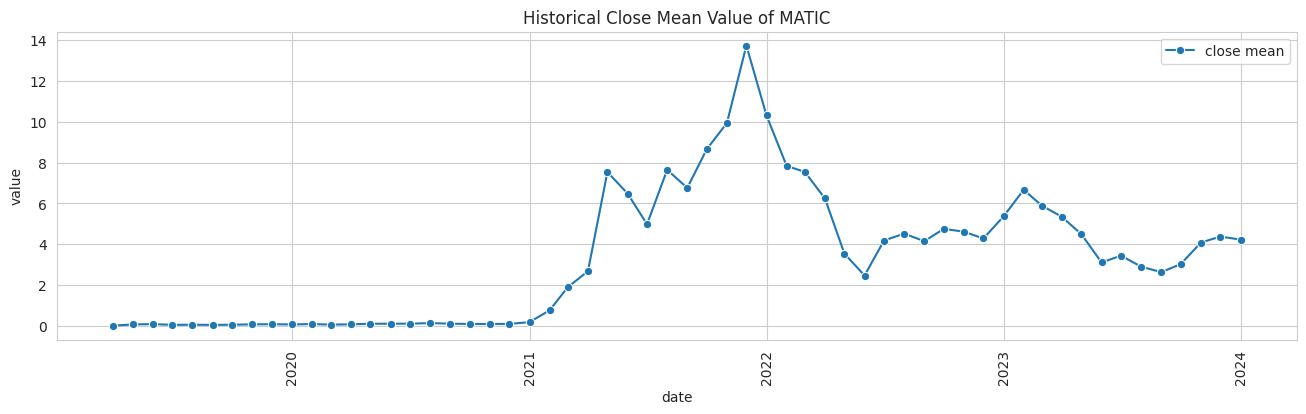

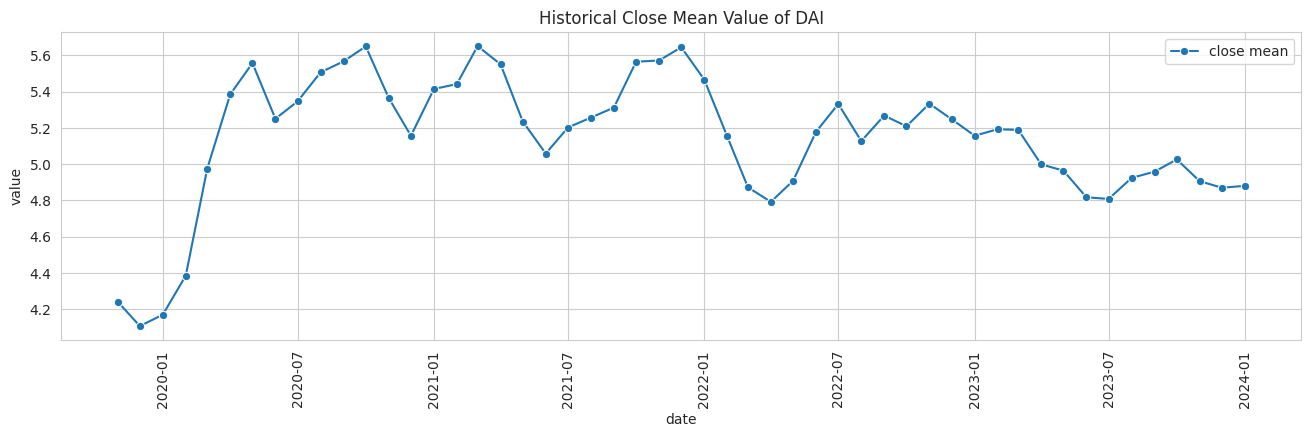

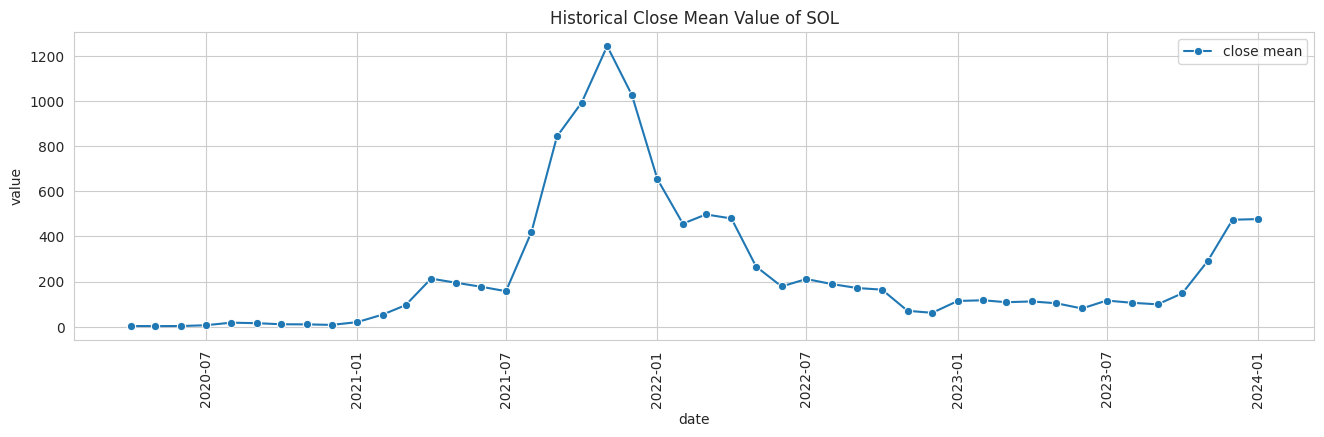

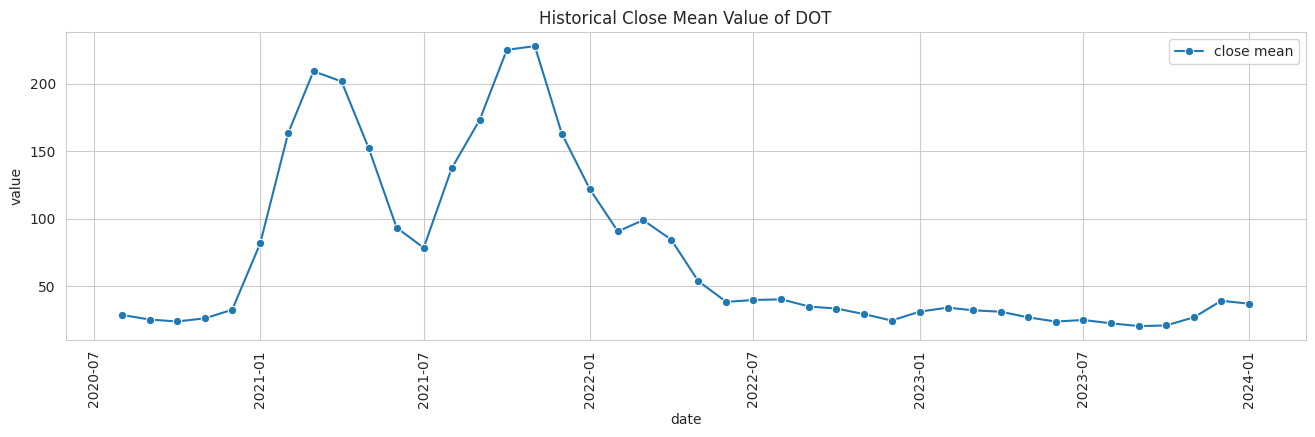

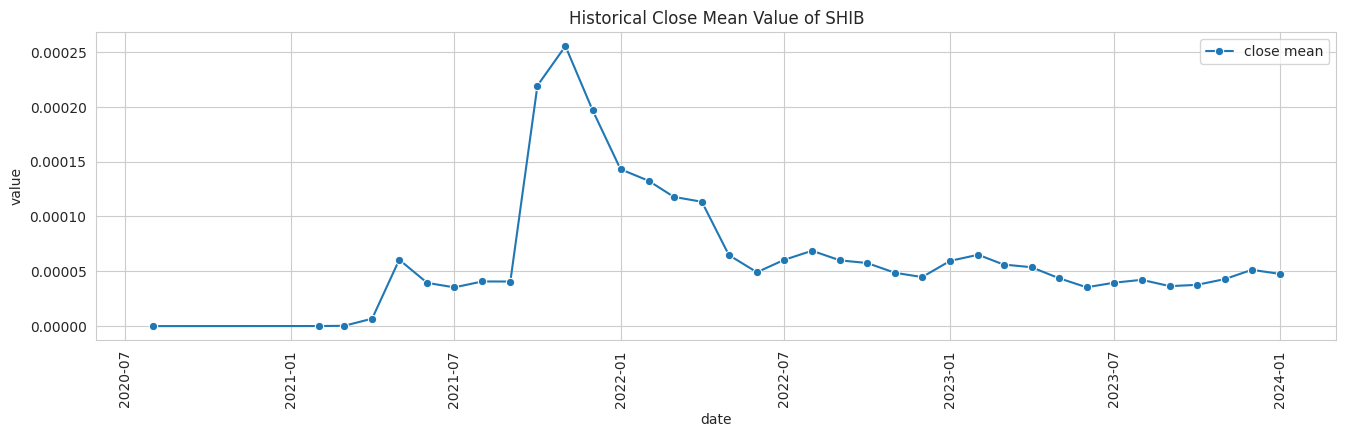

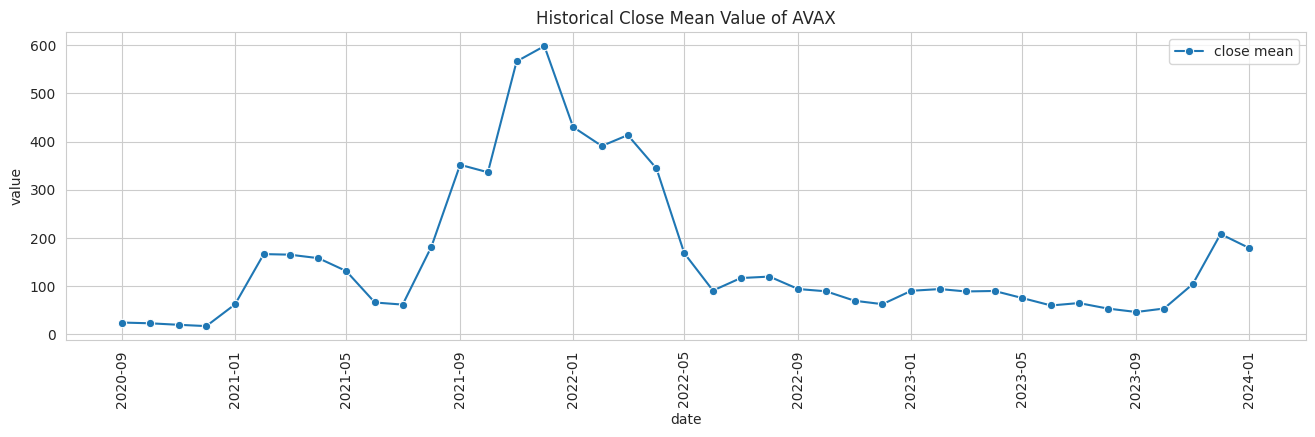

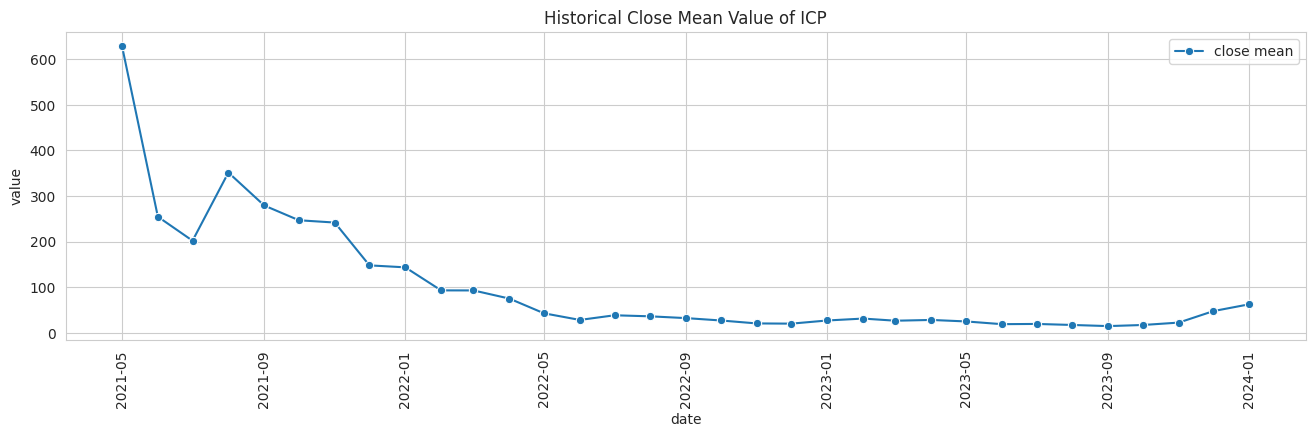

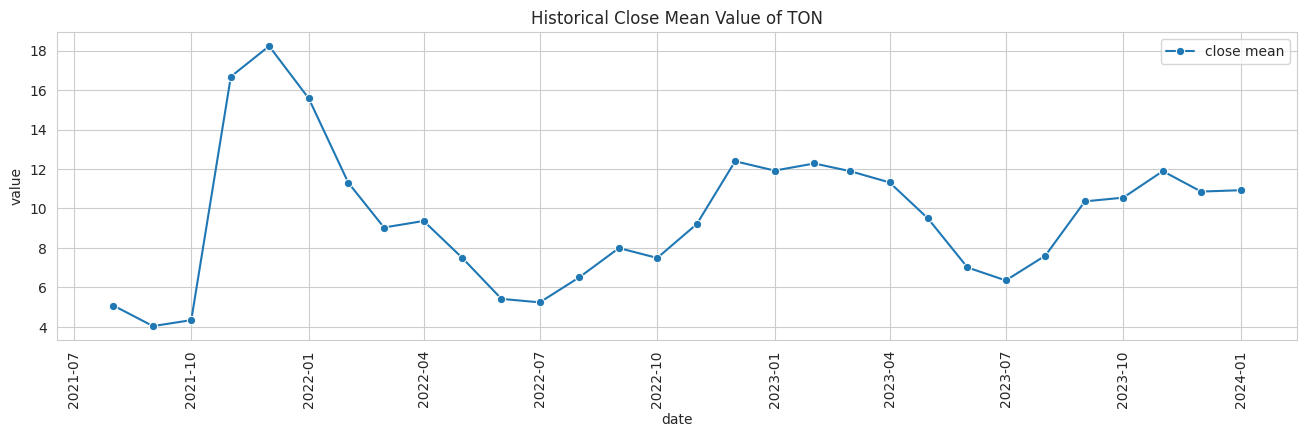

In [ ]:
df_month_mean['close_mean_log'] = np.log(df_month_mean['close_mean'] + 1)  # Adicionando 1 para evitar log(0)

for tk in df_month_mean["ticker"].unique():
  db_temp = df_month_mean[df_month_mean["ticker"] == tk]

  # Plotando o histórico
  sns.lineplot(x='month', y='close_mean', data=db_temp, label='close mean', marker='o')

  # Configurando o título e os rótulos dos eixos
  plt.title(f'Historical Close Mean Value of {tk}')
  plt.xlabel('date')
  plt.ylabel('value')

  # Girando os rótulos dos meses em 90 graus
  plt.xticks(rotation=90)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

In [ ]:
# # pivotando para colunas para usar as demais como features
# df_month_mean_pivot = df_month_mean.pivot_table(index='month', columns='ticker', values='close_mean')
# df_month_mean_pivot.columns = df_month_mean_pivot.columns.astype(str) # tornando todos os nomes string
# df_month_mean_pivot = df_month_mean_pivot.fillna(0)
# df_month_mean_pivot.columns.name = None # removendo o nome da tabela que apareceria como colune
# df_month_mean_pivot = df_month_mean_pivot.reset_index()
# df_month_mean_pivot

def pivotar_dataframe(df):
    """
    Realiza a pivotagem de um DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame a ser pivotado.

    Returns:
    - df_pivotado (pd.DataFrame): O DataFrame resultante após a pivotagem.

    Example:
    >>> df = pd.DataFrame({'month': ['2022-01-01', '2022-02-01'],
    ...                    'ticker': ['AAPL', 'AAPL'],
    ...                    'close_mean': [105.0, 106.5]})
    >>> df_pivotado = pivotar_dataframe(df)
    >>> print(df_pivotado.head())
           month   AAPL
    0 2022-01-01  105.0
    1 2022-02-01  106.5
    """
    # Pivotar o DataFrame
    df_pivotado = df.pivot_table(index='month', columns='ticker', values='close_mean')

    # Tornar todos os nomes de coluna como string
    df_pivotado.columns = df_pivotado.columns.astype(str)

    # Preencher valores ausentes com 0
    df_pivotado = df_pivotado.fillna(0)

    # Resetar o índice e remover o nome da coluna
    df_pivotado = df_pivotado.reset_index()
    df_pivotado.columns.name = None

    return df_pivotado

# exemplo
df_month_mean_pivot = pivotar_dataframe(df_month_mean)
df_month_mean_pivot

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213


## SALVANDO TABELAS

In [ ]:
# SAVE SILVER
#silver_path = glob.glob('../silver/')
silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
silver_filename = "df_silver.parquet"
silver_save_path = silver_path + silver_filename

df.to_parquet(silver_save_path)
df_month_mean.to_parquet(silver_path + "df_month_mean.parquet")

# SAVE GOLD
#gold_path = glob.glob('../gold/')
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
gold_filename = "df_gold.parquet"
gold_save_path = gold_save_path + gold_filename

df_month_mean_pivot.to_parquet(gold_save_path)

NameError: name 'df_month_mean' is not defined

In [ ]:
import pandas as pd
import os

def salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path):
    """
    Salva DataFrames em formatos específicos nos diretórios 'silver' e 'gold'.

    Parameters:
    - df (pd.DataFrame): O DataFrame principal a ser salvo em 'silver'.
    - df_month_mean (pd.DataFrame): O DataFrame a ser salvo em 'silver'.
    - df_month_mean_pivot (pd.DataFrame): O DataFrame a ser salvo em 'gold'.
    - silver_path (str): O caminho para o diretório 'silver'.
    - gold_path (str): O caminho para o diretório 'gold'.

    Returns:
    - None

    Example:
    >>> salvar_dados(df, df_month_mean, df_month_mean_pivot, "../crypto_forecast/silver/", "../crypto_forecast/gold/")
    """
    # Criar diretórios 'silver' e 'gold' se não existirem
    os.makedirs(silver_path, exist_ok=True)
    os.makedirs(gold_path, exist_ok=True)

    # Salvando no diretório 'silver'
    silver_filename = "df_silver.parquet"
    silver_save_path = os.path.join(silver_path, silver_filename)
    df.to_parquet(silver_save_path)

    df_month_mean_filename = "df_month_mean.parquet"
    df_month_mean_save_path = os.path.join(silver_path, df_month_mean_filename)
    df_month_mean.to_parquet(df_month_mean_save_path)

    # Salvando no diretório 'gold'
    gold_filename = "df_gold.parquet"
    gold_save_path = os.path.join(gold_path, gold_filename)
    df_month_mean_pivot.to_parquet(gold_save_path)

# exemplo
silver_path = glob.glob('../silver/')
gold_path = glob.glob('../gold/')

# silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
# gold_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"

salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path)

# ANALYSIS

- [X] Previsão Univariada
- [X] Previsão Multivariada
- [X] Previsão com modelos de Bagging e Boosting
- [ ] Geração de dados sintéticos para previsão com bagging/boosting
- [ ] Automatização de tudo

## Previsão Univariada

In [ ]:
df = pd.read_parquet(gold_save_path)
df.set_index("month", inplace=True)
df.head()

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.0,0.0,0.0,0.0,278.528200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,276.292200,0.0,0.0,0.0,0.0,0.0,0.0,6.332617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,215.594137,0.0,0.0,0.0,0.0,0.0,0.0,6.651075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,241.503268,0.0,0.0,0.0,0.0,0.0,0.0,6.530263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,322.417250,0.0,0.0,0.0,0.0,0.0,0.0,6.154942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for ticker in df_month_mean["ticker"].unique():
  df_temp = df_month_mean[df_month_mean["ticker"] == ticker]
  print(f"ticker: {ticker}, shape: {df_temp.shape[0]}")

ticker: BTC, shape: 130
ticker: LTC, shape: 129
ticker: XRP, shape: 125
ticker: DOGE, shape: 121
ticker: USDT, shape: 107
ticker: ETH, shape: 101
ticker: BCH, shape: 78
ticker: BNB, shape: 78
ticker: LINK, shape: 76
ticker: TRX, shape: 76
ticker: ADA, shape: 75
ticker: USDC, shape: 63
ticker: MATIC, shape: 58
ticker: DAI, shape: 51
ticker: SOL, shape: 46
ticker: DOT, shape: 42
ticker: SHIB, shape: 37
ticker: AVAX, shape: 41
ticker: ICP, shape: 33
ticker: TON, shape: 30


In [ ]:
# 130 - round(130 * 0.95)

In [ ]:
target = "BTC"

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2542.176, Time=4.51 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2807.060, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2566.490, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2716.109, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2808.148, Time=0.04 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=2541.615, Time=1.52 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=2565.008, Time=0.70 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=2541.852, Time=3.12 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=2544.630, Time=1.13 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=2543.822, Time=4.32 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=2545.601, Time=1.05 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=2543.928, Time=0.92 sec
 ARIMA(3,0,2)(0,1,1)[12] intercept   : AIC=2538.176, Time=2.32 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=2561.444, Time=0.73 sec
 ARIMA(3,0,2)(1,1,1

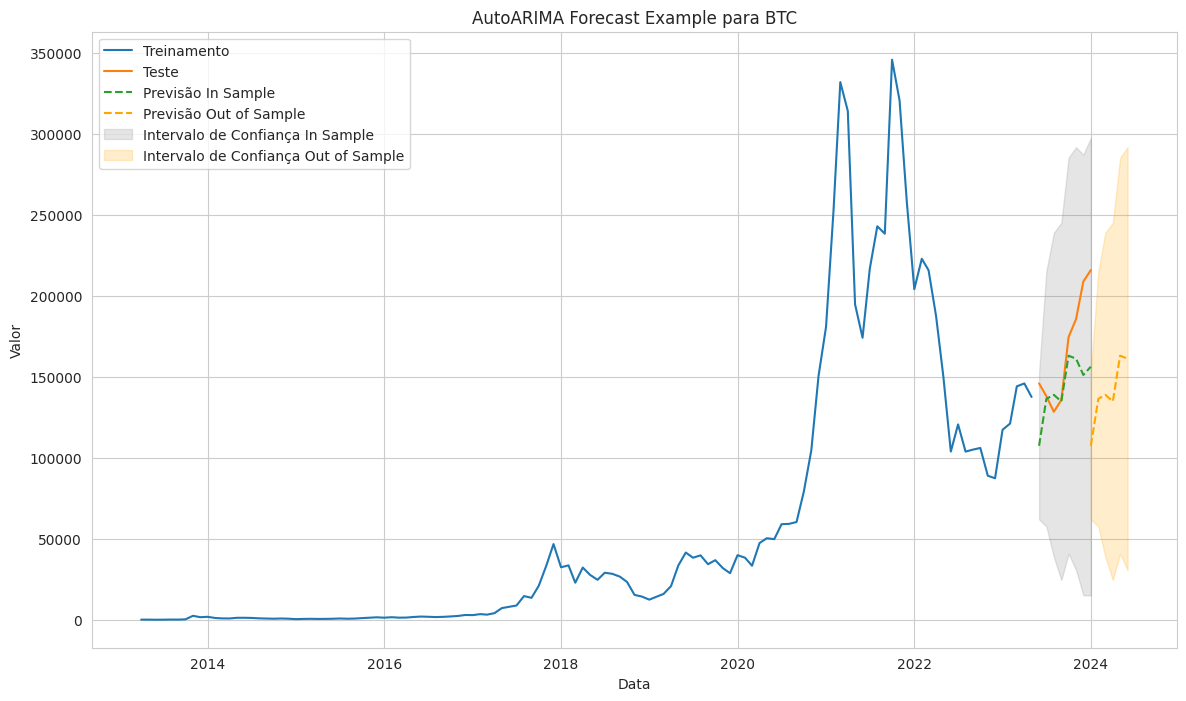

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# preparar os dados
# target = "ETH"
df_uni = df[df[target] > 0][[target]].copy()

# # Dividir os dados em treinamento e teste
# train_size = int(len(df_uni) * 0.95)
# train, test = df_uni[:train_size], df_uni[train_size:]

# Dividir os dados em treinamento e teste
train_size = len(df_uni) - 8 # ultimos 6 pontos
train, test = df_uni[:train_size], df_uni[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values,
                   seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                   information_criterion='aic',
                   trace=True, error_action='ignore', stepwise=True)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test), return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample, return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [ ]:
test

,BTC
month,
2023-06-01,145979.938192
2023-07-01,138144.427024
2023-08-01,128500.820776
2023-09-01,135716.038785
2023-10-01,174590.403638
2023-11-01,185712.655127
2023-12-01,208828.524615
2024-01-01,215901.032926


In [ ]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarima = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarima:.2f}%")

MAPE In Sample: 13.90%


## Previsão Multivariada

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=2542.176, Time=3.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2807.060, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2566.490, Time=1.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2716.109, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2808.148, Time=0.05 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=2541.615, Time=2.27 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=2565.008, Time=0.90 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=2541.852, Time=2.95 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=2544.630, Time=1.09 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=2543.822, Time=4.05 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=2545.601, Time=0.89 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=2543.928, Time=0.84 sec
 ARIMA(3,0,2)(0,1,1)[12] intercept   : AIC=2538.176, Time=2.34 sec
 ARIMA(3,0,2)(0,1,0)[12] intercept   : AIC=2561.444, Time=0.97 sec
 ARIMA(3,0,2)(1,1,1

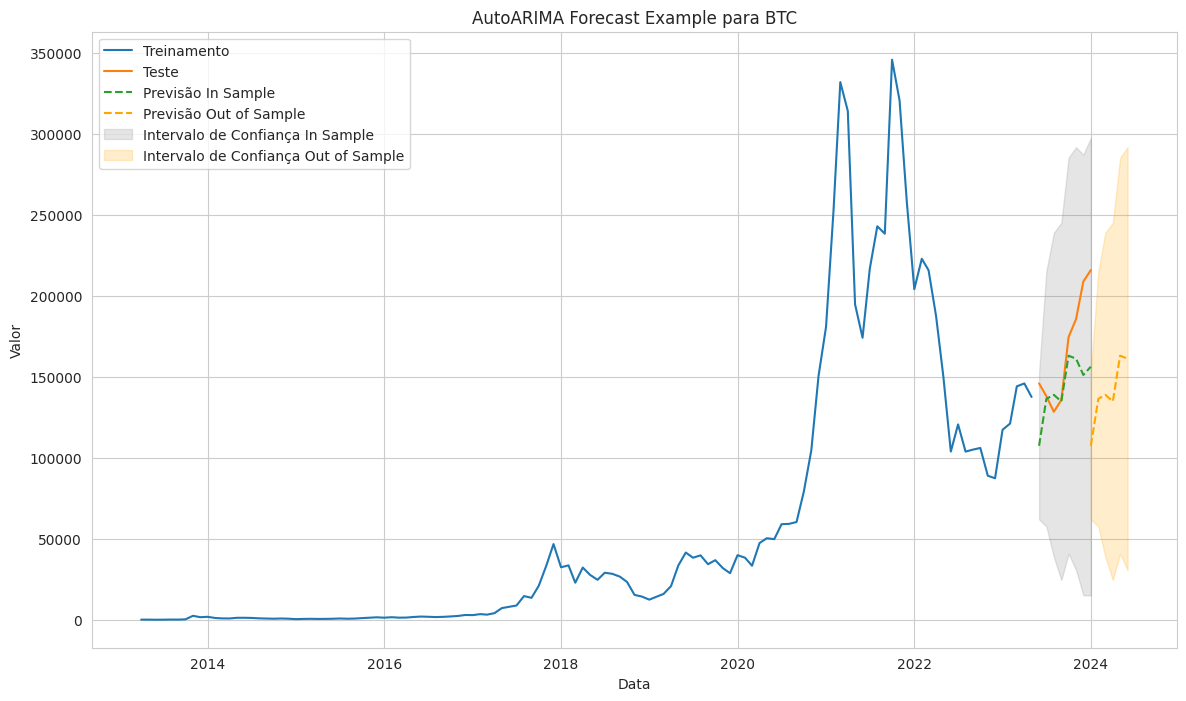

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# target = "ETH"

#exogenous_vars = [col for col in df.columns if col != target]
thresh = 0.8
correlations = df.corrwith(df[target], method="pearson")
exogenous_vars = correlations[(correlations.abs() > thresh)].index
exogenous_vars = exogenous_vars.to_list()
exogenous_vars = [column for column in exogenous_vars if column != target]
exogenous_vars

# # Dividir os dados em treinamento e teste
# train_size = int(len(df) * 0.95)
# train, test = df[:train_size], df[train_size:]

# Dividir os dados em treinamento e teste
train_size = len(df) - 8 # ultimos 6 pontos
train, test = df[:train_size], df[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values,
                   exogenous=train[exogenous_vars],
                   seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                   information_criterion='aic',
                   trace=True, error_action='ignore', stepwise=True)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test),
                                                       exogenous=test[exogenous_vars].values,
                                                       return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample,
                                                               exogenous=test.iloc[-1][exogenous_vars].values.reshape(1, -1),
                                                               return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train[target], label='Treinamento')
plt.plot(test[target], label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [ ]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarimax = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarimax:.2f}%")

MAPE In Sample: 13.90%


## Bagging e Boosting

In [ ]:
random_state = 42
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=random_state)

In [ ]:
#target = "ETH"
thresh = 0.9

correlations = df.corrwith(df[target], method="pearson")
high_correlation_columns = correlations[(correlations.abs() > thresh)].index
high_correlation_columns = high_correlation_columns.to_list()
high_correlation_columns = [column for column in high_correlation_columns if column != target]
high_correlation_columns

['BNB', 'DOT', 'ETH', 'LINK', 'TRX']

In [ ]:
from sklearn.metrics import mean_absolute_error

df_test = df.reset_index()
df_test

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=2)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

In [ ]:
df_test

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP,BTC_RF,BTC_XGB
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777,119519.512162,102050.296875
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081,155628.490765,151510.421875
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949,168061.392092,171954.234375
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213,172703.397089,152781.265625


In [ ]:
# Calcular o MAPE
df_test_mm = df_test[[f"{target}", f"{target}_RF", f"{target}_XGB"]].dropna()

actual_values = df_test_mm[target].values
predicted_values_in_sample_rf = df_test_mm[ f"{target}_RF"].values
predicted_values_in_sample_xgb = df_test_mm[ f"{target}_XGB"].values

mape_in_sample_rf = np.mean(np.abs((actual_values - predicted_values_in_sample_rf) / actual_values)) * 100
mape_in_sample_xgb = np.mean(np.abs((actual_values - predicted_values_in_sample_xgb) / actual_values)) * 100

print(f"Target: {target}")
print(f"MAPE In Sample ARIMA: {mape_in_sample_sarima:.2f}%")
print(f"MAPE In Sample SARIMAX: {mape_in_sample_sarimax:.2f}%")
print(f"MAPE In Sample RF: {mape_in_sample_rf:.2f}%")
print(f"MAPE In Sample XGB: {mape_in_sample_xgb:.2f}%")

Target: BTC
MAPE In Sample ARIMA: 13.90%
MAPE In Sample SARIMAX: 13.90%
MAPE In Sample RF: 15.12%
MAPE In Sample XGB: 23.35%


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

df_test = df.reset_index()

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=2)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Inicializando listas para armazenar métricas
metrics_rf_train = []
metrics_rf_test = []
metrics_xgb_train = []
metrics_xgb_test = []

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # MÉTRICAS
    # Métricas no conjunto de treinamento
    train_rmse_rf = mean_squared_error(y_train, random_forest_model.predict(X_train), squared=False)
    train_mape_rf = mean_absolute_error(y_train, random_forest_model.predict(X_train)) / y_train.mean() * 100
    metrics_rf_train.append({'Train_RMSE': train_rmse_rf, 'Train_MAPE': train_mape_rf})

    # Métricas no conjunto de teste
    test_rmse_rf = mean_squared_error(y_test, rf_predictions, squared=False)
    test_mape_rf = mean_absolute_error(y_test, rf_predictions) / y_test.mean() * 100
    metrics_rf_test.append({'Test_RMSE': test_rmse_rf, 'Test_MAPE': test_mape_rf})

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

    # Métricas no conjunto de treinamento
    train_rmse_xgb = mean_squared_error(y_train, xgboost_model.predict(X_train), squared=False)
    train_mape_xgb = mean_absolute_error(y_train, xgboost_model.predict(X_train)) / y_train.mean() * 100
    metrics_xgb_train.append({'Train_RMSE': train_rmse_xgb, 'Train_MAPE': train_mape_xgb})

    # Métricas no conjunto de teste
    test_rmse_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
    test_mape_xgb = mean_absolute_error(y_test, xgb_predictions) / y_test.mean() * 100
    metrics_xgb_test.append({'Test_RMSE': test_rmse_xgb, 'Test_MAPE': test_mape_xgb})

# Criando DataFrames com as métricas
df_metrics_rf_train = pd.DataFrame(metrics_rf_train)
df_metrics_rf_train['Model'] = 'RandomForest'

df_metrics_rf_test = pd.DataFrame(metrics_rf_test)
df_metrics_rf_test['Model'] = 'RandomForest'

df_metrics_xgb_train = pd.DataFrame(metrics_xgb_train)
df_metrics_xgb_train['Model'] = 'XGBoost'

df_metrics_xgb_test = pd.DataFrame(metrics_xgb_test)
df_metrics_xgb_test['Model'] = 'XGBoost'

# Juntando os DataFrames em um único DataFrame
metrics_rf =  pd.concat([df_metrics_rf_train, df_metrics_rf_test], axis=1)
metrics_xgb =  pd.concat([df_metrics_xgb_train, df_metrics_xgb_test], axis=1)

df_all_metrics = pd.concat([metrics_rf, metrics_xgb],  axis=0) #, ignore_index=True)
df_all_metrics[["Model", "Train_RMSE", "Test_RMSE", "Train_MAPE", "Test_MAPE"]]

,Model,Model,Train_RMSE,Test_RMSE,Train_MAPE,Test_MAPE
0,RandomForest,RandomForest,5356.373914,26117.999185,4.393494,18.309575
1,RandomForest,RandomForest,5587.484290,18753.970177,4.697163,14.078888
2,RandomForest,RandomForest,5483.927851,26700.099937,4.584357,14.807833
3,RandomForest,RandomForest,5199.581720,27934.152625,4.347499,13.153833
0,XGBoost,XGBoost,267.245717,39597.974996,0.168277,27.537676
1,XGBoost,XGBoost,265.182968,36647.360386,0.165631,27.655219
2,XGBoost,XGBoost,263.033688,21863.058718,0.159339,12.131917
3,XGBoost,XGBoost,260.976496,55057.729227,0.152336,25.869817


# OUT OF SAMPLE FORECAST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
gold_filename = "df_gold.parquet"
gold_file_path = gold_save_path + gold_filename

df = pd.read_parquet(gold_file_path)
df.set_index("month", inplace=True)
df.head()

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.0,0.0,0.0,0.0,278.528200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,276.292200,0.0,0.0,0.0,0.0,0.0,0.0,6.332617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,215.594137,0.0,0.0,0.0,0.0,0.0,0.0,6.651075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,241.503268,0.0,0.0,0.0,0.0,0.0,0.0,6.530263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,322.417250,0.0,0.0,0.0,0.0,0.0,0.0,6.154942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
silver_path = glob.glob('../silver/')
silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"

df_forecast = pd.read_parquet(silver_path + "df_month_mean.parquet")
df_forecast.set_index("month", inplace=True)
df_forecast["type"] = "HIST"
df_forecast["model"] = "HIST"
df_forecast = df_forecast[["ticker", "close_mean", "type", "model"]].copy()
df_forecast

,ticker,close_mean,type,model
month,,,,
2013-04-01,BTC,278.528200,HIST,HIST
2013-05-01,BTC,276.292200,HIST,HIST
2013-05-01,LTC,6.332617,HIST,HIST
2013-06-01,BTC,215.594137,HIST,HIST
2013-06-01,LTC,6.651075,HIST,HIST
...,...,...,...,...
2024-01-01,TON,10.922831,HIST,HIST
2024-01-01,TRX,0.521461,HIST,HIST
2024-01-01,USDC,4.882848,HIST,HIST


In [ ]:
# COLETAR MELHORES PARAMETROS PARA CADA TICKER, SALVAR NUM DICIONARIO COM {TICKER:{BEST_ORDER: VALOR, BEST_SEASONAL_ORDER: VALOR}} OK
# CRIAR HISTORICO E PREVISAO, SALVAR RESULTADOS FAZENDO APPEND, PARA TODOS OS TICKERS COM AUTOARIMA

# CONFIG
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "best_params_dict.json"
gold_save_path = gold_save_path + filename
best_params_dict = {}

import os

def processar_e_salvar_params(gold_save_path, filename, df, build_best_params=False):
    """
    Processa os parâmetros para cada ticker no DataFrame df usando auto_arima e salva os resultados em um arquivo JSON.

    Parameters:
    - gold_save_path (str): Caminho onde o arquivo será salvo.
    - filename (str): Nome do arquivo a ser salvo.
    - df (pandas.DataFrame): DataFrame contendo os dados para os quais os parâmetros serão calculados.
    - build_best_params (bool, optional): Indica se deve criar um novo arquivo de parâmetros ou apenas verificar se o arquivo já existe.
                                          Se True, cria um novo arquivo; se False (padrão), verifica a existência do arquivo.

    Returns:
    None

    Example:
    processar_e_salvar_params(gold_save_path, "best_params_dict.json", df, build_best_params=False)
    """

    # Verificando se o arquivo já existe
    if os.path.exists(gold_save_path) and not build_best_params:
        print(f'O conjunto de parâmetros para cada ticker {filename} já existe. Não foi criado um novo arquivo.')
    else:
        best_params_dict = {}
        for tk in tqdm(df.columns, desc=f"Processando parâmetros para {tk}"):
            model = auto_arima(df[tk].values, seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3, information_criterion='aic', trace=False, error_action='ignore', stepwise=True)
            best_order = model.order
            best_seasonal_order = model.seasonal_order
            best_params_dict[tk] = {"best_order": model.order, "best_seasonal_order": model.seasonal_order}

        # Salvando o dicionário usando json
        with open(gold_save_path, 'w') as arquivo:
            json.dump(best_params_dict, arquivo)
        print(f'Dicionário salvo em {gold_save_path}')

# Exemplo de chamada da função
processar_e_salvar_params(gold_save_path, "best_params_dict.json", df, build_best_params=False)

O conjunto de parâmetros para cada ticker best_params_dict.json já existe. Não foi criado um novo arquivo.


In [ ]:
# Carregando o dicionário do arquivo JSON
with open(gold_save_path, 'r') as arquivo:
    best_params_dict = json.load(arquivo)

best_params_dict

{'ADA': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'AVAX': {'best_order': [2, 0, 1], 'best_seasonal_order': [0, 1, 1, 12]},
 'BCH': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'BNB': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'BTC': {'best_order': [1, 0, 1], 'best_seasonal_order': [1, 1, 1, 12]},
 'DAI': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'DOGE': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'DOT': {'best_order': [3, 0, 2], 'best_seasonal_order': [2, 1, 1, 12]},
 'ETH': {'best_order': [3, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'ICP': {'best_order': [3, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'LINK': {'best_order': [2, 0, 1], 'best_seasonal_order': [3, 1, 0, 12]},
 'LTC': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'MATIC': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'SHIB': {'best_order': [1, 0, 0], 'best_seaso

In [6]:
import json

def carregar_dicionario_params(caminho_arquivo):
    """
    Carrega um dicionário a partir de um arquivo JSON.

    Parameters:
    - caminho_arquivo (str): O caminho para o arquivo JSON a ser carregado.

    Returns:
    - dict: O dicionário carregado a partir do arquivo JSON.

    Example:
    >>> best_params_dict = carregar_dicionario("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_gold.parquet")
    >>> print(best_params_dict)
    {'BTC': {'best_order': (1, 1, 1), 'best_seasonal_order': (0, 1, 1, 12)}, ...}
    """
    with open(caminho_arquivo, 'r') as arquivo:
        dicionario_carregado = json.load(arquivo)

    return dicionario_carregado

# exemplo
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "best_params_dict.json"
gold_save_path = gold_save_path + filename
best_params_dict = {}
best_params_dict = carregar_dicionario_params(gold_save_path)
best_params_dict

{'ADA': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'AVAX': {'best_order': [2, 0, 1], 'best_seasonal_order': [0, 1, 1, 12]},
 'BCH': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'BNB': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'BTC': {'best_order': [1, 0, 1], 'best_seasonal_order': [1, 1, 1, 12]},
 'DAI': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'DOGE': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'DOT': {'best_order': [3, 0, 2], 'best_seasonal_order': [2, 1, 1, 12]},
 'ETH': {'best_order': [3, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'ICP': {'best_order': [3, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'LINK': {'best_order': [2, 0, 1], 'best_seasonal_order': [3, 1, 0, 12]},
 'LTC': {'best_order': [1, 0, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'MATIC': {'best_order': [1, 0, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'SHIB': {'best_order': [1, 0, 0], 'best_seaso

In [7]:
# BEST_ORDER = best_params_dict["BTC"]["best_order"]
# BEST_SEASONAL_ORDER = best_params_dict["BTC"]["best_seasonal_order"]
# BEST_ORDER, BEST_SEASONAL_ORDER

In [8]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# target = "BTC"
# BEST_ORDER = best_params_dict["BTC"]["best_order"]
# BEST_SEASONAL_ORDER = best_params_dict["BTC"]["best_seasonal_order"]
# n_periods_out_of_sample = 6

# model = SARIMAX(df['BTC'], order=BEST_ORDER,  seasonal_order=BEST_SEASONAL_ORDER)
# res = model.fit()

# n_periods_out_of_sample = 6  # ou qualquer valor desejado
# # forecast_out_of_sample = res.predict(n_periods=n_periods_out_of_sample, steps=n_periods_out_of_sample)
# fs = res.get_forecast(steps=n_periods_out_of_sample)
# fs_values = fs.predicted_mean
# fs_lower_bound = fs.conf_int().iloc[:,0]
# fs_upper_bound = fs.conf_int().iloc[:,1]

# fs_values_df = fs_values.reset_index()
# fs_values_df["lower_bound"] = fs_lower_bound.values
# fs_values_df["upper_bound"] = fs_upper_bound.values

# # Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
# forecast_index_out_of_sample = pd.date_range(start=df['BTC'].index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
# fs_df = pd.DataFrame(fs_values.values, columns=[f'close_mean'], index=fs_values.index)
# fs_df["lower_bound"] = fs_lower_bound.values
# fs_df["upper_bound"] = fs_upper_bound.values
# fs_df["ticker"] = target
# fs_df["type"] = "PRED"

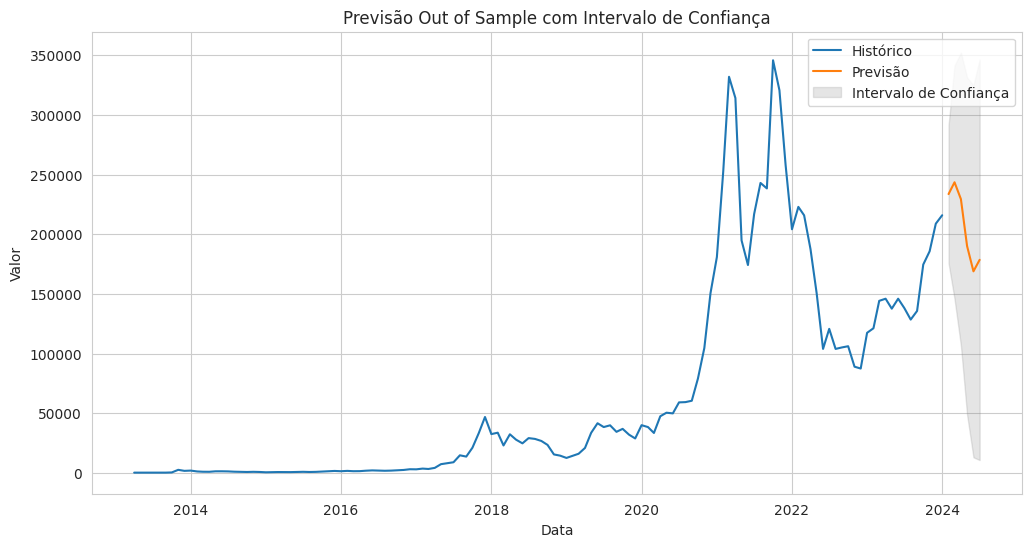

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plotar o gráfico usando Seaborn
# plt.figure(figsize=(12, 6))
# plt.plot(df['BTC'], label='Histórico', )
# sns.lineplot(data=fs_df["close_mean"], label='Previsão')
# plt.fill_between(fs_df.index, fs_df["lower_bound"], fs_df["upper_bound"], color='gray', alpha=0.2, label='Intervalo de Confiança', )

# plt.title('Previsão Out of Sample com Intervalo de Confiança')
# plt.xlabel('Data')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# fs_df = pd.DataFrame()

# n_periods_out_of_sample = 6
# for tk, params in tqdm(best_params_dict.items()):
#   print(f" Prevendo valores para {tk}")
# #  for key in tqdm(best_params_dict.keys(), desc=f"Prevendo valores para {tk}"):
#   BEST_ORDER = best_params_dict[f"{tk}"]["best_order"]
#   BEST_SEASONAL_ORDER = best_params_dict[f"{tk}"]["best_seasonal_order"]

#   model = SARIMAX(df[f'{tk}'], order=BEST_ORDER,  seasonal_order=BEST_SEASONAL_ORDER)
#   res = model.fit()

#   fs = res.get_forecast(steps=n_periods_out_of_sample)
#   fs_values = fs.predicted_mean
#   fs_lower_bound = fs.conf_int().iloc[:,0]
#   fs_upper_bound = fs.conf_int().iloc[:,1]

#   fs_values_df = fs_values.reset_index()
#   fs_values_df["lower_bound"] = fs_lower_bound.values
#   fs_values_df["upper_bound"] = fs_upper_bound.values

#   # Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
#   #forecast_index_out_of_sample = pd.date_range(start=df['BTC'].index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
#   fs_df_new = pd.DataFrame(fs_values.values, columns=[f'close_mean'], index=fs_values.index)
#   fs_df_new["lower_bound"] = np.where(fs_lower_bound.values <  0, fs_lower_bound.values, 0)
#   fs_df_new["upper_bound"] = fs_upper_bound.values
#   fs_df_new["ticker"] = tk
#   fs_df_new["type"] = "PRED"
#   fs_df_new["model"] = "SARIMA"

#   fs_df = fs_df.append(fs_df_new)

In [11]:
import warnings
warnings.filterwarnings('ignore')

def gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6):
    """
    Gera previsões utilizando o modelo SARIMAX para várias séries temporais.

    Parameters:
    - df (pd.DataFrame): O DataFrame contendo as séries temporais.
    - best_params_dict (dict): Um dicionário contendo os melhores parâmetros para cada série.
    - n_periods_out_of_sample (int): O número de períodos para prever out-of-sample.

    Returns:
    - fs_df (pd.DataFrame): Um DataFrame contendo as previsões, intervalos de confiança e informações adicionais.

    Example:
    >>> df = ...  # Seu DataFrame com séries temporais
    >>> best_params_dict = {'BTC': {'best_order': (1, 1, 1), 'best_seasonal_order': (0, 1, 1, 12)}}
    >>> fs_df = gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6)
    >>> print(fs_df.head())
             close_mean  lower_bound  upper_bound ticker  type
    2023-01-01    ...         ...         ...       BTC  PRED
    ...           ...         ...         ...       ...  ...
    """
    fs_df = pd.DataFrame()

    print("Gerando Previsões SARIMAX")
    for tk, params in tqdm(best_params_dict.items()):

        print(f" Prevendo valores para {tk}")
        BEST_ORDER = params["best_order"]
        BEST_SEASONAL_ORDER = params["best_seasonal_order"]

        print(df[f'{tk}.head()')
        model = SARIMAX(df[f'{tk}'], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER, freq="MS")
        res = model.fit()

        fs = res.get_forecast(steps=n_periods_out_of_sample)
        fs_values = fs.predicted_mean
        fs_lower_bound = fs.conf_int().iloc[:, 0]
        fs_upper_bound = fs.conf_int().iloc[:, 1]

        #  fs_values_df = pd.DataFrame(fs_values.values, columns=[f'close_mean'], index=fs_values.index)
        fs_values_df = fs_values.reset_index()
        fs_values_df["lower_bound"] = np.where(fs_lower_bound.values < 0, fs_lower_bound.values, 0)
        fs_values_df["upper_bound"] = fs_upper_bound.values
        fs_values_df["ticker"] = tk
        fs_values_df["type"] = "PRED"
        fs_values_df["model"] = "SARIMA"

        #print(fs_values_df)
        fs_df = fs_df.append(fs_values_df)

    fs_df.rename(columns={"predicted_mean": "close_mean"}, inplace=True)
    fs_df.set_index("index", inplace=True)
    return fs_df

fs_df = gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6)

Gerando Previsões SARIMAX


  0%|          | 0/20 [00:00<?, ?it/s]

 Prevendo valores para ADA


  5%|▌         | 1/20 [00:03<01:04,  3.38s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01        3.256122     0.000000     5.265387    ADA  PRED  SARIMA
1 2024-03-01        3.044911     0.000000     5.801309    ADA  PRED  SARIMA
2 2024-04-01        2.997921    -0.278590     6.274432    ADA  PRED  SARIMA
3 2024-05-01        3.080458    -0.594385     6.755301    ADA  PRED  SARIMA
4 2024-06-01        2.592069    -1.401804     6.585942    ADA  PRED  SARIMA
5 2024-07-01        2.554694    -1.701140     6.810528    ADA  PRED  SARIMA
 Prevendo valores para AVAX


 10%|█         | 2/20 [00:06<00:56,  3.15s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01      145.919452     0.000000   220.883011   AVAX  PRED  SARIMA
1 2024-03-01      155.222756     0.000000   278.513607   AVAX  PRED  SARIMA
2 2024-04-01      133.700416   -11.914361   279.315193   AVAX  PRED  SARIMA
3 2024-05-01      102.482843   -61.625519   266.591206   AVAX  PRED  SARIMA
4 2024-06-01       76.796697  -100.549814   254.143208   AVAX  PRED  SARIMA
5 2024-07-01       76.388603  -111.579637   264.356844   AVAX  PRED  SARIMA
 Prevendo valores para BCH


 15%|█▌        | 3/20 [00:15<01:40,  5.94s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01     1423.945831  -175.064616  3022.956278    BCH  PRED  SARIMA
1 2024-03-01     1601.524179  -484.805657  3687.854015    BCH  PRED  SARIMA
2 2024-04-01     2422.901413     0.000000  4792.342491    BCH  PRED  SARIMA
3 2024-05-01     1726.998671  -822.574290  4276.571631    BCH  PRED  SARIMA
4 2024-06-01     1469.960174 -1198.879410  4138.799759    BCH  PRED  SARIMA
5 2024-07-01     1628.771819 -1120.750024  4378.293661    BCH  PRED  SARIMA
 Prevendo valores para BNB


 20%|██        | 4/20 [00:21<01:34,  5.89s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01     1543.718849          0.0  2110.979678    BNB  PRED  SARIMA
1 2024-03-01     1539.356489          0.0  2323.177880    BNB  PRED  SARIMA
2 2024-04-01     1643.776678          0.0  2581.791100    BNB  PRED  SARIMA
3 2024-05-01     1416.942399          0.0  2476.288941    BNB  PRED  SARIMA
4 2024-06-01     1253.466389          0.0  2412.484411    BNB  PRED  SARIMA
5 2024-07-01     1255.383324          0.0  2498.368217    BNB  PRED  SARIMA
 Prevendo valores para BTC


 25%|██▌       | 5/20 [00:23<01:09,  4.61s/it]

       index  predicted_mean  lower_bound    upper_bound ticker  type   model
0 2024-02-01   233614.336931          0.0  291523.077591    BTC  PRED  SARIMA
1 2024-03-01   243514.714491          0.0  341165.503934    BTC  PRED  SARIMA
2 2024-04-01   229418.815973          0.0  352026.739866    BTC  PRED  SARIMA
3 2024-05-01   190081.845603          0.0  331221.415489    BTC  PRED  SARIMA
4 2024-06-01   168907.923169          0.0  324684.574019    BTC  PRED  SARIMA
5 2024-07-01   178548.882968          0.0  346270.955735    BTC  PRED  SARIMA
 Prevendo valores para DAI


 30%|███       | 6/20 [00:27<00:59,  4.24s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01        4.855221          0.0     5.751026    DAI  PRED  SARIMA
1 2024-03-01        4.946330          0.0     6.197100    DAI  PRED  SARIMA
2 2024-04-01        4.925831          0.0     6.438420    DAI  PRED  SARIMA
3 2024-05-01        4.900727          0.0     6.625520    DAI  PRED  SARIMA
4 2024-06-01        4.838568          0.0     6.743093    DAI  PRED  SARIMA
5 2024-07-01        4.940802          0.0     7.001529    DAI  PRED  SARIMA
 Prevendo valores para DOGE


 35%|███▌      | 7/20 [00:31<00:56,  4.37s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01        0.389182     0.000000     0.725228   DOGE  PRED  SARIMA
1 2024-03-01        0.374085    -0.079421     0.827590   DOGE  PRED  SARIMA
2 2024-04-01        0.825377     0.000000     1.356254   DOGE  PRED  SARIMA
3 2024-05-01        0.743617     0.000000     1.330455   DOGE  PRED  SARIMA
4 2024-06-01        0.586295    -0.042791     1.215380   DOGE  PRED  SARIMA
5 2024-07-01        0.530906    -0.130862     1.192674   DOGE  PRED  SARIMA
 Prevendo valores para DOT


 40%|████      | 8/20 [00:41<01:13,  6.12s/it]

       index  predicted_mean  lower_bound  upper_bound ticker  type   model
0 2024-02-01       35.512770     0.000000    56.725908    DOT  PRED  SARIMA
1 2024-03-01       26.675940   -14.902402    68.254283    DOT  PRED  SARIMA
2 2024-04-01       21.263303   -39.477900    82.004505    DOT  PRED  SARIMA
3 2024-05-01       20.298638   -52.785359    93.382635    DOT  PRED  SARIMA
4 2024-06-01       21.797412   -56.723435   100.318260    DOT  PRED  SARIMA
5 2024-07-01       25.561643   -54.858297   105.981582    DOT  PRED  SARIMA
 Prevendo valores para ETH


 40%|████      | 8/20 [00:42<01:03,  5.32s/it]


KeyboardInterrupt: 

In [10]:
fs_df

,close_mean,lower_bound,upper_bound,ticker,type,model
index,,,,,,
2024-02-01,3.256122,0.000000,5.265387,ADA,PRED,SARIMA
2024-03-01,3.044911,0.000000,5.801309,ADA,PRED,SARIMA
2024-04-01,2.997921,-0.278590,6.274432,ADA,PRED,SARIMA
2024-05-01,3.080458,-0.594385,6.755301,ADA,PRED,SARIMA
2024-06-01,2.592069,-1.401804,6.585942,ADA,PRED,SARIMA
...,...,...,...,...,...,...
2024-03-01,3.118957,0.000000,5.497595,XRP,PRED,SARIMA
2024-04-01,4.140545,0.000000,6.686511,XRP,PRED,SARIMA
2024-05-01,3.157084,0.000000,5.832864,XRP,PRED,SARIMA


In [ ]:
df_forecast_results = df_forecast.append(fs_df)
df_forecast_results

,ticker,close_mean,type,model,lower_bound,upper_bound
2013-04-01,BTC,278.528200,HIST,HIST,NaN,NaN
2013-05-01,BTC,276.292200,HIST,HIST,NaN,NaN
2013-05-01,LTC,6.332617,HIST,HIST,NaN,NaN
2013-06-01,BTC,215.594137,HIST,HIST,NaN,NaN
2013-06-01,LTC,6.651075,HIST,HIST,NaN,NaN
...,...,...,...,...,...,...
2024-03-01,XRP,3.118957,PRED,SARIMA,0.000000,5.497595
2024-04-01,XRP,4.140545,PRED,SARIMA,0.000000,6.686511
2024-05-01,XRP,3.157084,PRED,SARIMA,0.000000,5.832864
2024-06-01,XRP,2.461873,PRED,SARIMA,-0.316151,5.239898


In [ ]:
df_forecast_results.to_parquet("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_forecast_results.parquet")

# PLOT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df_plot = pd.read_parquet("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_forecast_results.parquet")
df_plot

,ticker,close_mean,type,model,lower_bound,upper_bound
month,,,,,,
2013-04-01,BTC,278.528200,HIST,HIST,NaN,NaN
2013-05-01,BTC,276.292200,HIST,HIST,NaN,NaN
2013-05-01,LTC,6.332617,HIST,HIST,NaN,NaN
2013-06-01,BTC,215.594137,HIST,HIST,NaN,NaN
2013-06-01,LTC,6.651075,HIST,HIST,NaN,NaN
...,...,...,...,...,...,...
2024-03-01,XRP,3.118955,PRED,SARIMA,0.000000,5.497594
2024-04-01,XRP,4.140541,PRED,SARIMA,0.000000,6.686508
2024-05-01,XRP,3.157081,PRED,SARIMA,0.000000,5.832862


In [12]:
!pip install -U gradio --quiet

In [13]:
# Carregar o DataFrame fornecido
# Substitua 'caminho/do/arquivo.csv' pelo caminho real do seu arquivo CSV ou carregue os dados de outra maneira.
#df_plot = pd.read_csv('caminho/do/arquivo.csv', parse_dates=['timestamp'])

import gradio as gr

# Função para plotar o gráfico com base nos parâmetros fornecidos
def plot_graph(ticker, start_date):
    filtered_df = df_plot[(df_plot['ticker'] == ticker) & (df_plot['timestamp'] >= start_date)]

    fig = px.line(filtered_df, x='timestamp', y='close_mean', title=f'{ticker} Close Mean Over Time')
    fig.update_layout(xaxis_title='Date', yaxis_title='Close Mean')

    return fig

# Definir as opções para a caixa de seleção
ticker_options = list(df_plot['ticker'].unique())

# Criar a interface Gradio
iface = gr.Interface(fn=plot_graph,
                     inputs=[
                         gr.SelectBox(choices=ticker_options, label='Select Ticker'),
                         gr.DatePicker(label='Select Start Date', default='2018-01-01')
                     ],
                     outputs=gr.Plot(type='plotly'))

# Lançar a interface
iface.launch()

ImportError: cannot import name 'TypeAliasType' from 'typing_extensions' (/usr/local/lib/python3.10/dist-packages/typing_extensions.py)

In [ ]:
df_plot #.head() #[df_plot.index == "2023-02-01"]

,ticker,close_mean,type,model,lower_bound,upper_bound
2013-04-01,BTC,278.528200,HIST,HIST,NaN,NaN
2013-05-01,BTC,276.292200,HIST,HIST,NaN,NaN
2013-05-01,LTC,6.332617,HIST,HIST,NaN,NaN
2013-06-01,BTC,215.594137,HIST,HIST,NaN,NaN
2013-06-01,LTC,6.651075,HIST,HIST,NaN,NaN
...,...,...,...,...,...,...
2024-03-01,XRP,3.118957,PRED,SARIMA,0.000000,5.497595
2024-04-01,XRP,4.140545,PRED,SARIMA,0.000000,6.686511
2024-05-01,XRP,3.157084,PRED,SARIMA,0.000000,5.832864
2024-06-01,XRP,2.461873,PRED,SARIMA,-0.316151,5.239898


In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "HIST"].index,
                    y=df_ticker[df_ticker["type"] == "HIST"]["close_mean"],
                    mode='lines', name=f'{ticker}', )

    # Adicionar linha para PRED (tracejada)
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Filtrar os dados para HIST e PRED
df_hist = df_plot_subplot[df_plot_subplot["type"] == "HIST"]
df_pred = df_plot_subplot[df_plot_subplot["type"] == "PRED"]

# Criar o gráfico
fig = px.line()

# Adicionar as linhas para HIST
df_ticker_hist = df_hist[df_hist["ticker"] == ticker]
fig.add_scatter(x=df_ticker_hist.index, y=df_ticker_hist["close_mean"], mode='lines', name=f'{ticker}') #, line=dict(color='blue'))

# Adicionar as linhas para PRED (tracejadas)
df_ticker_pred = df_pred[df_pred["ticker"] == ticker]
fig.add_scatter(x=df_ticker_pred.index, y=df_ticker_pred["close_mean"], mode='lines', line=dict(dash='dash'), name=f'{ticker}')

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Filtrar os dados para HIST e PRED
df_hist = df_plot_subplot[df_plot_subplot["type"] == "HIST"]
df_pred = df_plot_subplot[df_plot_subplot["type"] == "PRED"]

# Criar o gráfico
fig = px.line()

# Adicionar as linhas para HIST
for ticker in tk:
    df_ticker_hist = df_hist[df_hist["ticker"] == ticker]
    fig.add_scatter(x=df_ticker_hist.index, y=df_ticker_hist["close_mean"],
                    mode='lines') #, name=f'{ticker}') #, line=dict(color='blue'))

# Adicionar as linhas para PRED (tracejadas)
for ticker in tk:
    df_ticker_pred = df_pred[df_pred["ticker"] == ticker]
    fig.add_scatter(x=df_ticker_pred.index, y=df_ticker_pred["close_mean"],
                    mode='lines', line=dict(dash='dash')) #name=f'{ticker}', line=dict(dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()

In [ ]:
#tk = ["XRP", "DOGE"]
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]
# plx.line(df_plot_subplot, y="close_mean", color="ticker", hover_data="type", hover_name="type")

# # Atualize a formatação dos eixos x e y
# fig.update_layout(
#     xaxis_tickformat="%d/%m/%Y",  # Formato desejado para o eixo x (data)
#     yaxis_tickformat=",.2f"        # Formato desejado para o eixo y (números)
# )


# Seu código para criar o DataFrame df_plot_subplot...

# Crie o gráfico utilizando o Plotly Express
fig = px.line(df_plot_subplot, y="close_mean", color="ticker", hover_name="ticker", hover_data=["type", "model"])

# Atualize a formatação dos eixos x e y
fig.update_layout(
#    xaxis_tickformat="%d/%m/%Y",  # Formato desejado para o eixo x (data)
    yaxis_tickformat=",.2f"        # Formato desejado para o eixo y (números)
)

# Exiba o gráfico
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
# df_plot_subplot = ...

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "HIST"].index,
                    y=df_ticker[df_ticker["type"] == "HIST"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(color='blue'))

    # Adicionar linha para PRED (tracejada)
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(color='red', dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
    # Adicionar estilo para as linhas PRED (tracejadas)
    legend=dict(traceorder='reversed'),
)

# Exibir o gráfico
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
# df_plot_subplot = ...

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST e PRED
    fig.add_scatter(x=df_ticker.index,
                    y=df_ticker["close_mean"],
                    mode='lines',
                    name=f'{ticker}',
                    line=dict(dash='solid'),  # Linha HIST
                    legendgroup=f'{ticker}')

    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines',
                    name=f'{ticker}',
                    line=dict(dash='dash'),  # Linha PRED
                    legendgroup=f'{ticker}')

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
    legend=dict(traceorder='reversed'),
)

# Exibir o gráfico
fig.show()


In [ ]:
df_plot_subplot[df_plot_subplot["ticker"] == "ETH"].index.min(), df_plot_subplot[df_plot_subplot["ticker"] == "ETH"].index.max(), df_plot_subplot[df_plot_subplot["ticker"] == "BTC"].index.min(), df_plot_subplot[df_plot_subplot["ticker"] == "BTC"].index.max()

(Timestamp('2018-02-01 00:00:00'),
 Timestamp('2024-07-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2024-07-01 00:00:00'))

In [ ]:
import pandas as pd
import os

def salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path):
    """
    Salva DataFrames em formatos específicos nos diretórios 'silver' e 'gold'.

    Parameters:
    - df (pd.DataFrame): O DataFrame principal a ser salvo em 'silver'.
    - df_month_mean (pd.DataFrame): O DataFrame a ser salvo em 'silver'.
    - df_month_mean_pivot (pd.DataFrame): O DataFrame a ser salvo em 'gold'.
    - silver_path (str): O caminho para o diretório 'silver'.
    - gold_path (str): O caminho para o diretório 'gold'.

    Returns:
    - None

    Example:
    >>> salvar_dados(df, df_month_mean, df_month_mean_pivot, "../crypto_forecast/silver/", "../crypto_forecast/gold/")
    """
    # Criar diretórios 'silver' e 'gold' se não existirem
    os.makedirs(silver_path, exist_ok=True)
    os.makedirs(gold_path, exist_ok=True)

    # Salvando no diretório 'silver'
    silver_filename = "df_silver.parquet"
    silver_save_path = os.path.join(silver_path, silver_filename)
    df.to_parquet(silver_save_path)

    df_month_mean_filename = "df_month_mean.parquet"
    df_month_mean_save_path = os.path.join(silver_path, df_month_mean_filename)
    df_month_mean.to_parquet(df_month_mean_save_path)

    # Salvando no diretório 'gold'
    gold_filename = "df_gold.parquet"
    gold_save_path = os.path.join(gold_path, gold_filename)
    df_month_mean_pivot.to_parquet(gold_save_path)

    df_forecast_results_name = "df_forecast_results.parquet"
    gold_save_path = os.path.join(gold_path, df_forecast_results_name)
    df_forecast_results.to_parquet(gold_save_path)

# exemplo
# silver_path = glob.glob('../silver/')
# gold_path = glob.glob('../gold/')

silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
gold_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"

salvar_dados(df, df_month_mean, df_month_mean_pivot, df_forecast_results, silver_path, gold_path)

NameError: name 'df_month_mean' is not defined

In [ ]:
# TO-DO
## PREVISAO COM BAGGING/BOSSTING
## GERAÇÃO DE DADOS SINTÉTICOS
## PREVISÃO
## ARMAENAMENTO